# Look at changes in clapping rates by location

This notebook visualises the median clapping rate for members of an audience. Hypothesis: people who are near each other converge in clapping rate faster than those who are not. 

In [75]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import imageio


In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [ ]:
%reload_ext autoreload

In [103]:
# Now to map those values to locations, need to import some details.
# these are old ID codes, need to replace. 
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

internal_mlmotion = general_loc + 'Internal/Motion_ML/'
internal_ax3 = general_loc +  'Internal/Motion_AX3/'
internal_Part = general_loc + 'Internal/Participants/'
internal_time = general_loc + 'Internal/Timing/'

In [104]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
partDets = partDets.loc[~partDets['X'].isna(),:]


,Participant_Code,MusicLab_DevID
0,ADQ001,0ab9bf2b-a0c7-f823-0fde-6295eedb207e
1,ADQ002,2b36bb42-2be3-9075-0de9-1cc9d3480a55
2,ADQ003,3aa57dd8-4d97-a01d-61ff-3139f2f2609b
3,ADQ004,49472968-4242-c1b7-98c2-3a5c60c33d39
4,ADQ005,6cfe2eb8-ea15-b8c9-053c-f6645e2d4e25
...,...,...
86,AEQ087,2119fe13-3a70-e293-0818-60c9574580f1
87,AEQ088,2db31f15-6d47-da79-ab6a-02b55c6d065b
88,AEQ089,891551b7-70e2-2032-3ea0-3a3335b15901
89,AER090,NaN


## Load a clapping section
individual claps 

In [153]:
Clap_files = os.listdir('./Data/clapping_data/clapping_peaks/')
clapname = Clap_files[2]
# 5 finale, 13 schnittke, 3 beethoven, 2 bach
clapname

'bach_peaks.csv'

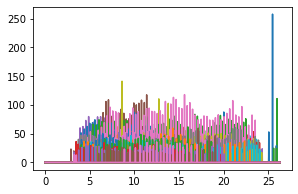

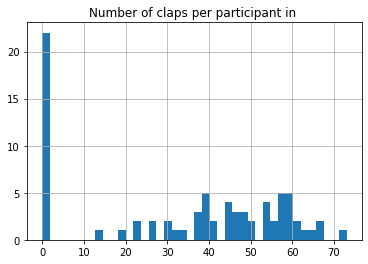

[77, 0.7142857142857143]


In [154]:
# read file
peaks = pd.read_csv('./Data/clapping_data/clapping_peaks/' + clapname)
exp_name = filename[:-10]
peaks.drop(columns=['index'],inplace = True)
peaks = peaks.fillna(0)
ts = pd.Series(np.arange(0,len(peaks))*0.02)
t_end = ts.iloc[-1]

df_claps = pd.DataFrame(index = ts,data = peaks.values,columns = peaks.columns)
df_claps.plot(figsize = [2+t_end/10,3],legend = False)
plt.show()
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant in ' + exp_name)
plt.show()

a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>0])/len(a)])
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>0]]
#df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)
# Evaluate length or recording 

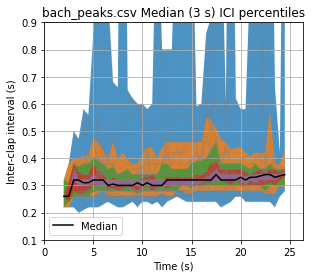

In [155]:
if t_end>15:
    # evaluate clapp statistics
    t_interval = 1.5
    sampletimes = np.arange(0+t_interval,t_end-t_interval,0.5)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)

    for samp in range(len(sampletimes)):
        t_0 = sampletimes[samp]
        sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
        clap_stats = []
        cols = sub_claps.columns
        these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
        for partn in cols:
            ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
            if ici.notna().sum()>0:
                these_claps[partn]=np.nanmedian(ici)
        Clap_Feats.loc[t_0] = these_claps
    # plot statistics
    df_A = Clap_Feats.copy()
    df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','Midrange','NotNa_C','NotNa_p'])
    df_spans = pd.DataFrame(index = df_A.index,columns = ['Upper','Lower'])
    t_interval = 3
    cntiles = np.array([0,0.1,0.2,0.3,0.4])
    for i, row in df_A.iterrows():
        sub_row = row[row.notna()]
        if len(sub_row)>0:
            these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                           'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
            df_feats.loc[i,:] = these_stats
    df_feats = df_feats.dropna()

    fig,ax = plt.subplots(1,1,figsize=[2+t_end/10,4])
    df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
    #ax.line(df_A.index,df_A)
    df_feats.plot(y='Median',color="black", ax=ax)

    for pc in cntiles:
        for i, row in df_A.iterrows():
            sub_row = row[row.notna()]
            if len(sub_row)>0:
                these_stats = {'Lower':sub_row.quantile(q=pc,interpolation='nearest'),'Upper':sub_row.quantile(q=1-pc,interpolation='nearest')}
                df_spans.loc[i,:] = these_stats
        df_spans = df_spans.dropna()

        x = np.array(df_spans.index)
        y1 = np.array(df_spans.Lower,dtype=np.float32)
        y2 = np.array(df_spans.Upper,dtype=np.float32)
        ax.fill_between(x,y1,y2,alpha = 0.8)

    plt.ylim([0.1,0.9])
    plt.xlim([0,t_end])
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Inter-clap interval (s)')
    plt.title(clapname +' Median (3 s) ICI percentiles')
    plt.savefig(clapname+'_Applause_Local_ICI_medians_CentileTS.png',dpi=400)
    plt.show()

In [156]:
# since the participant codes pedate the new codes with current locations, need to use old map to connect the details
old_C = Clap_Feats.columns
new_C = []
for part in old_C:
    new_C.append(partDets.loc[partDets['MusicLab_DevID']==part,'Participant_Code'].values[0])
Clap_Feats.columns = new_C

ClapDets=partDets.loc[partDets['Participant_Code'].isin(new_C),:]
Clap_Feats = Clap_Feats[ClapDets['Participant_Code']]
Clap_Feats.fillna(0,inplace = True)

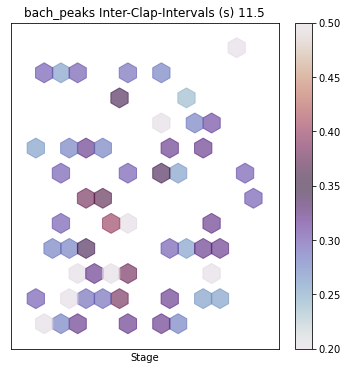

In [157]:
i = 20
plt.figure(figsize=[6,6])
plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values, cmap='twilight', vmin=0.2, vmax=0.5, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(Clap_Feats.iloc[i,:].name))
cbar = plt.colorbar()
# cbar.solids.set_edgecolor("face")
# plt.draw()
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

In [158]:
# convert to claps per minute?
Clap_Rates = Clap_Feats.copy()
Clap_Rates = Clap_Rates.replace(0, np.nan)


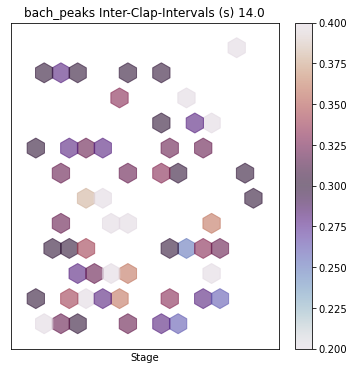

In [159]:
i = 25
plt.figure(figsize=[6,6])
plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values, cmap='twilight', vmin=0.2, vmax=0.4, s=400, marker="h", alpha=0.6)
plt.xlim([-8,8])
plt.ylim([0,13])
plt.xticks([])
plt.yticks([])
plt.xlabel('Stage')
plt.title(clapname[:-4] + ' Inter-Clap-Intervals (s) ' + str(Clap_Feats.iloc[i,:].name))
cbar = plt.colorbar()
# cbar.solids.set_edgecolor("face")
# plt.draw()
# show the graph
#plt.savefig('./plots/Audience_Devices.png',dpi = 300)
plt.show()

In [160]:
# generate gif with this 
filenames = []
for i in range(len(Clap_Feats)):
    # plot the line chart
    plt.figure(figsize=[6,6])
    plt.scatter(x=ClapDets['Y'],y=ClapDets['X'], c=Clap_Feats.iloc[i,:].values,  cmap='twilight', vmin=0.2, vmax=0.5, s=400, marker="h", alpha=0.6)
    plt.xlim([-8,8])
    plt.ylim([0,13])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Stage')
    plt.title(clapname[:-4] + ' ICIs ' + str(Clap_Feats.iloc[i,:].name))
    cbar = plt.colorbar()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# extend the last image before looping
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
filenames.append(filename)
# build gif
gif_path = './plots/Clapping_'+clapname[:-4]+'_ICI_2hz.gif'
with imageio.get_writer(gif_path, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

# TODO

- Recollect peaks including those from the AX3s
- Look at pairwise local ICI medians for all relationships (spatial, social)